# Practice Assignment: Understanding Distributions Through Sampling

** *This assignment is optional, and I encourage you to share your solutions with me and your peers in the discussion forums!* **


To complete this assignment, create a code cell that:
* Creates a number of subplots using the `pyplot subplots` or `matplotlib gridspec` functionality.
* Creates an animation, pulling between 100 and 1000 samples from each of the random variables (`x1`, `x2`, `x3`, `x4`) for each plot and plotting this as we did in the lecture on animation.
* **Bonus:** Go above and beyond and "wow" your classmates (and me!) by looking into matplotlib widgets and adding a widget which allows for parameterization of the distributions behind the sampling animations.


Tips:
* Before you start, think about the different ways you can create this visualization to be as interesting and effective as possible.
* Take a look at the histograms below to get an idea of what the random variables look like, as well as their positioning with respect to one another. This is just a guide, so be creative in how you lay things out!
* Try to keep the length of your animation reasonable (roughly between 10 and 30 seconds).

In [29]:
%matplotlib notebook

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button

<IPython.core.display.Javascript object>


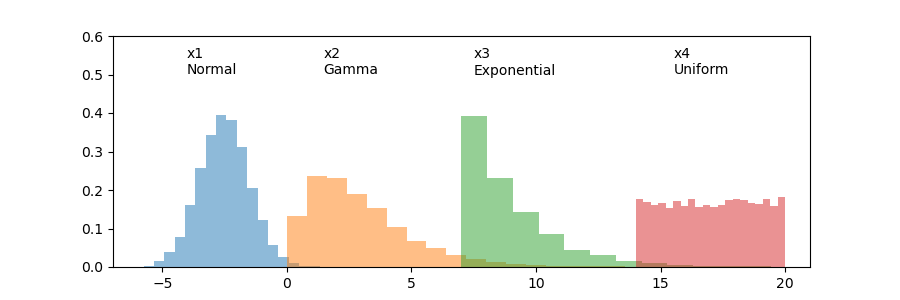

Text(15.519487857835124, 0.5, 'x4\nUniform')

In [31]:
# generate 4 random variables from the random, gamma, exponential, and uniform distributions
x1 = np.random.normal(-2.5, 1, 10000)
x2 = np.random.gamma(2, 1.5, 10000)
x3 = np.random.exponential(2, 10000)+7
x4 = np.random.uniform(14,20, 10000)

# plot the histograms
plt.figure(figsize=(9,3))
plt.hist(x1, density=True, bins=20, alpha=0.5)
plt.hist(x2, density=True, bins=20, alpha=0.5)
plt.hist(x3, density=True, bins=20, alpha=0.5)
plt.hist(x4, density=True, bins=20, alpha=0.5);
plt.axis([-7,21,0,0.6])

plt.text(x1.mean()-1.5, 0.5, 'x1\nNormal')
plt.text(x2.mean()-1.5, 0.5, 'x2\nGamma')
plt.text(x3.mean()-1.5, 0.5, 'x3\nExponential')
plt.text(x4.mean()-1.5, 0.5, 'x4\nUniform')

## Animate the four plots and provide users the ability to set parameter values.
* Automatically choose the number of bins based on the Meeden paper.
* Let users parameterize the four distributions and set the sample size.
* Animate sampling from each distribution.

In [32]:
# This function generates the data for the four distributions, 
# applies Meeden's method, and determines bin count and bin boundaries

def make_data():
    global x1, x2, x3, x4, bins1, bins2, bins3, bins4, n
    d = {} # create a dictionary to hold plotting results
    distn, bins, loss, upper_limit = ([] for i in range(4)) # Meeden's loss function and max density value for plotting
    # The four distributions.
    x1 = np.random.normal(N_mu_slider.val, N_sig_slider.val, np.int(np.ceil(N_obs_slider.val)))
    x2 = np.random.gamma(G_shape_slider.val, G_scale_slider.val, np.int(np.ceil(N_obs_slider.val)))
    x3 = np.random.exponential(E_rate_slider.val, np.int(np.ceil(N_obs_slider.val)))
    x4 = np.random.uniform(U_min_slider.val, U_max_slider.val, np.int(np.ceil(N_obs_slider.val)))
    n = np.int(np.ceil(N_obs_slider.val)) # sample size.

    # Apply the Meeden binning method to choose bin count.
    for i, var in enumerate((x1,x2,x3,x4)):
        np.seterr(divide='ignore', invalid='ignore')
        d["min_x{}".format(i+1)] = min(var) # lower limit for each plot
        d["max_x{}".format(i+1)] = max(var) # upper limit for each plot
        
        for k in np.arange(5,21,1):
           # np.seterr(divide='ignore', invalid='ignore')
            nu_k, bin_edges = np.histogram(var, k)
            p_k = nu_k/n
            m_k = np.repeat(1/k, len(p_k))
            rXk = -sum((nu_k/n)*np.log(nu_k/n))/np.log(k)
            ckx = (((1-1/k)/(n+1))**(1+(1-rXk)))**-1
        
            distn.append("x{}".format(i+1))
            bins.append(k)
            loss.append(ckx * sum((p_k-m_k)**2))
            upper_limit.append(max(p_k/abs(bin_edges[0]-bin_edges[1])))
            results = pd.DataFrame({'Distribution': distn, "Bins": bins, "Loss":loss, "Upper_Limit": upper_limit}).dropna(axis=0)
            results = results.loc[results.groupby("Distribution")['Loss'].idxmin()]

        #np.seterr(divide='warn', invalid='warn')
        
    import re
    d['min_g'] = min([v for k, v in d.items() if re.search('min',k) != None]) # global lower limit
    d['max_g'] = max([v for k, v in d.items() if re.search('max',k) != None]) # global upper limit
    
    # Get the bin boundaries.
    bins1 = np.arange(d['min_x1'], d['max_x1'], (d['max_x1']-d['min_x1'])/list(results.loc[results["Distribution"] == 'x1', 'Bins']))
    bins2 = np.arange(d['min_x2'], d['max_x2'], (d['max_x2']-d['min_x2'])/list(results.loc[results["Distribution"] == 'x2', 'Bins']))
    bins3 = np.arange(d['min_x3'], d['max_x3'], (d['max_x3']-d['min_x3'])/list(results.loc[results["Distribution"] == 'x3', 'Bins']))
    bins4 = np.arange(d['min_x4'], d['max_x4'], (d['max_x4']-d['min_x4'])/list(results.loc[results["Distribution"] == 'x4', 'Bins']))

In [33]:
# Update function (i.e., animate function)
def update(curr):
    if curr >= n: # sometimes n skips over the boundary value if running on local machine.
        a.event_source.stop()
    plt.cla()
    
    fig3.suptitle('\nSampling from Four Distributions', fontsize = 20) # Title for all four plots
    
    f3_ax1.cla() # Plot the Normal.
    f3_ax1.set_ylabel('Density')
    f3_ax1.hist(x1[:curr], density = True, bins = bins1, alpha = 0.50, color = 'darkorange')
    f3_ax1.set_title("Normal ($x_1$)\nn = {}".format(curr+1))
    
    f3_ax2.cla() # Plot the Gamma.
    f3_ax2.hist(x2[:curr], density = True, bins = bins2, alpha = 0.50, color = 'royalblue')
    f3_ax2.set_title("Gamma ($x_2$)\nn = {}".format(curr+1))
    
    f3_ax3.cla() # Plot the Exponential
    f3_ax3.set_ylabel('Density')
    f3_ax3.set_xlabel('Value')
    f3_ax3.hist(x3[:curr], density = True, bins = bins3, alpha = 0.50, color = 'forestgreen')
    f3_ax3.set_title("\n\nExponential ($x_3$)\nn = {}".format(curr+1))
    
    f3_ax4.cla() # Plot the Uniform.
    f3_ax4.set_xlabel('Value')
    f3_ax4.hist(x4[:curr], density = True, bins = bins4, alpha = 0.50, color = 'darkmagenta')
    f3_ax4.set_title("\n\nUniform ($x_4$)\nn = {}".format(curr+1))
    
    f3_ax5.cla() # Make some space (this uses gridspec) for the sliders and buttons.
    f3_ax5.set_title("Parameterize Variables:\n(Do not adjust parameters while simulation is running)")
    f3_ax5.axis('off')

In [34]:
# Once parameters are set and the "Simulate!" button is pressed,
# this function makes everything 'go.'
def animate_button(self):
    make_data()
    a = animation.FuncAnimation(fig3, update, n, interval=100, repeat = False)
    fig3.canvas.draw()

<IPython.core.display.Javascript object>


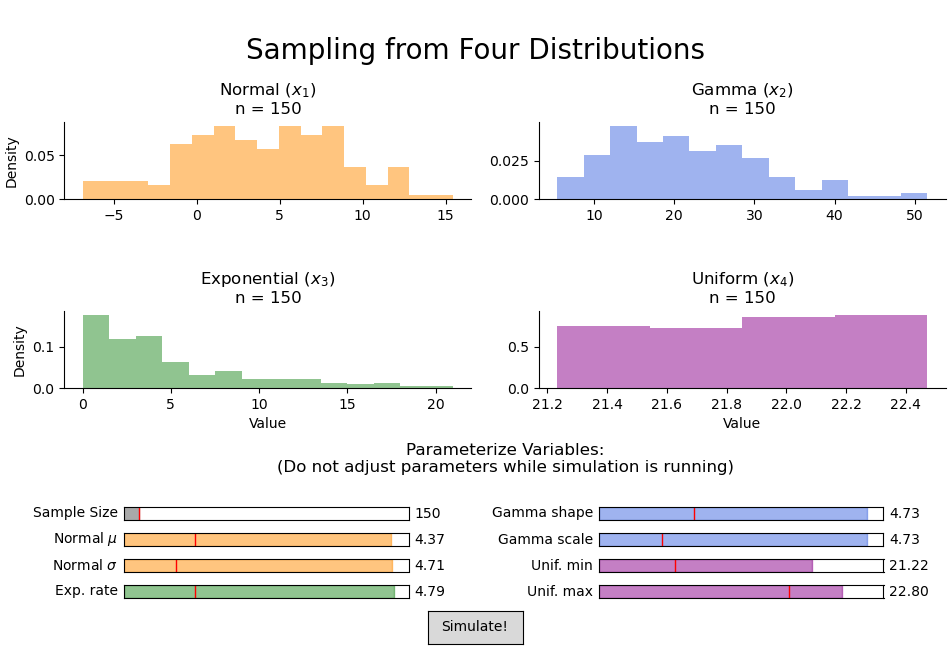

In [36]:
# Use gridspec to setup the plot space.
fig3 = plt.figure(constrained_layout=True, figsize = (9.5,6.5))
gs = fig3.add_gridspec(4, 2)

fig3.suptitle('\nSampling from Four Distributions', fontsize = 20)

f3_ax1 = fig3.add_subplot(gs[0, 0]) # where to put x1
f3_ax2 = fig3.add_subplot(gs[0, 1]) # where to put x2
f3_ax3 = fig3.add_subplot(gs[1, 0]) # where to put x3
f3_ax4 = fig3.add_subplot(gs[1, 1]) # where to put x4

f3_ax1.cla() # Normal distribution plotting window.
f3_ax1.set_title("Normal ($x_1$)")
f3_ax1.spines['right'].set_visible(False)
f3_ax1.set_ylabel('Density')
f3_ax1.spines['top'].set_visible(False)

f3_ax2.cla() # Gamma distribution plotting window.
f3_ax2.set_title("Gamma ($x_2$)")
f3_ax2.spines['right'].set_visible(False)
f3_ax2.spines['top'].set_visible(False)

f3_ax3.cla() # Exponential distribution plotting window.
f3_ax3.set_title("Exponential ($x_3$)")
f3_ax3.spines['right'].set_visible(False)
f3_ax3.set_ylabel('Density')
f3_ax3.spines['top'].set_visible(False)
f3_ax3.set_xlabel('Value')

f3_ax4.cla() # Uniform distribution plotting window.
f3_ax4.set_title("Uniform ($x_4$)")
f3_ax4.spines['right'].set_visible(False)
f3_ax4.set_xlabel('Value')
f3_ax4.spines['top'].set_visible(False)

f3_ax5 = fig3.add_subplot(gs[2, :]) # Slider and button space
f3_ax5.cla()
f3_ax5.set_title("Parameterize Variables:\n(Do not adjust parameters while simulation is running)")
f3_ax5.axis('off')

# Put the sliders and buttons in two columns...

# Allocate space (column on left) for parameter sliders.
N_obs_slider_ax = fig3.add_axes([0.13, .20, 0.3, 0.02])
N_mu_slider_ax = fig3.add_axes([0.13, .16, 0.3, 0.02])
N_sig_slider_ax = fig3.add_axes([0.13, .12, 0.3, 0.02])
E_rate_slider_ax = fig3.add_axes([0.13, .08, 0.3, 0.02])

axnextA = fig3.add_axes([0.45, 0.01, 0.1, 0.05])

# Allocate space (column on right) for parameter sliders.
G_shape_slider_ax = fig3.add_axes([0.63, .20, 0.3, 0.02])
G_scale_slider_ax = fig3.add_axes([0.63, .16, 0.3, 0.02])
U_min_slider_ax = fig3.add_axes([0.63, .12, 0.3, 0.02])
U_max_slider_ax = fig3.add_axes([0.63, .08, 0.3, 0.02])

# Write the sliders to the left column.
N_obs_slider  = Slider(N_obs_slider_ax, 'Sample Size', valmin = 100, valmax = 1000, valinit = 150, valfmt='%0.0f', color = 'darkgrey') 
N_obs_slider.label.set_size(10)

N_mu_slider = Slider(N_mu_slider_ax, 'Normal $\mu$', valmin = -5, valmax = 5, valinit = -2.5, color = 'darkorange', alpha = 0.50)
N_mu_slider.label.set_size(10)

N_sig_slider = Slider(N_sig_slider_ax, 'Normal $\sigma$', 0.1, 5, valinit = 1, color = 'darkorange', alpha = 0.50)
N_sig_slider.label.set_size(10)

E_rate_slider = Slider(E_rate_slider_ax, 'Exp. rate', valmin = 1, valmax = 5, valinit = 2, color = 'forestgreen', alpha = 0.50)
E_rate_slider.label.set_size(10)

# Write the sliders to the right column.
G_shape_slider = Slider(G_shape_slider_ax, 'Gamma shape', valmin = 0.5, valmax = 5, valinit = 2, color = 'royalblue', alpha = 0.50)
G_shape_slider.label.set_size(10)

G_scale_slider = Slider(G_scale_slider_ax, 'Gamma scale', valmin = 0.5, valmax = 5, valinit = 1.5, color = 'royalblue', alpha = 0.50)
G_scale_slider.label.set_size(10)

U_min_slider = Slider(U_min_slider_ax, 'Unif. min', 10, 25, valinit = 14, color = 'darkmagenta', alpha = 0.50)
U_min_slider.label.set_size(10)

U_max_slider = Slider(U_max_slider_ax, 'Unif. max', 10, 25, valinit = 20, color = 'darkmagenta', alpha = 0.50)
U_max_slider.label.set_size(10)

# Write out button to start simulation.
bnextA = Button(axnextA, "Simulate!")
bnextA.on_clicked(animate_button)

plt.show()